<a href="https://colab.research.google.com/github/Pelmenoff/data_science/blob/main/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.truncated_normal([in_features, out_features], stddev=0.1), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=None):
        y = tf.matmul(x, self.w) + self.b
        if activation:
            return activation(y)
        return y

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="output")


  def __call__(self, x):
        x = self.layer1(x, activation=tf.nn.relu)
        x = self.layer2(x, activation=tf.nn.relu)
        x = self.out_layer(x)
        return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
    return loss

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  # (Adam видає значно кращий результат)
  optimizer = tf.optimizers.Adam(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as tape:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    gradients = tape.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

    return loss

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step: 100, Loss: 0.2644282579421997, Accuracy: 0.9375
Step: 200, Loss: 0.23288843035697937, Accuracy: 0.95703125
Step: 300, Loss: 0.1400657296180725, Accuracy: 0.9765625
Step: 400, Loss: 0.12280406802892685, Accuracy: 0.98046875
Step: 500, Loss: 0.11762319505214691, Accuracy: 0.984375
Step: 600, Loss: 0.11498195677995682, Accuracy: 0.98046875
Step: 700, Loss: 0.10036364197731018, Accuracy: 0.9921875
Step: 800, Loss: 0.15842163562774658, Accuracy: 0.98046875
Step: 900, Loss: 0.09293852746486664, Accuracy: 0.984375
Step: 1000, Loss: 0.10281912982463837, Accuracy: 0.98828125
Step: 1100, Loss: 0.16315987706184387, Accuracy: 0.9765625
Step: 1200, Loss: 0.07676499336957932, Accuracy: 0.9921875
Step: 1300, Loss: 0.028672492131590843, Accuracy: 1.0
Step: 1400, Loss: 0.012669753283262253, Accuracy: 1.0
Step: 1500, Loss: 0.12195254862308502, Accuracy: 0.9921875
Step: 1600, Loss: 0.11400588601827621, Accuracy: 0.984375
Step: 1700, Loss: 0.06785150617361069, Accuracy: 0.99609375
Step: 1800, Loss: 

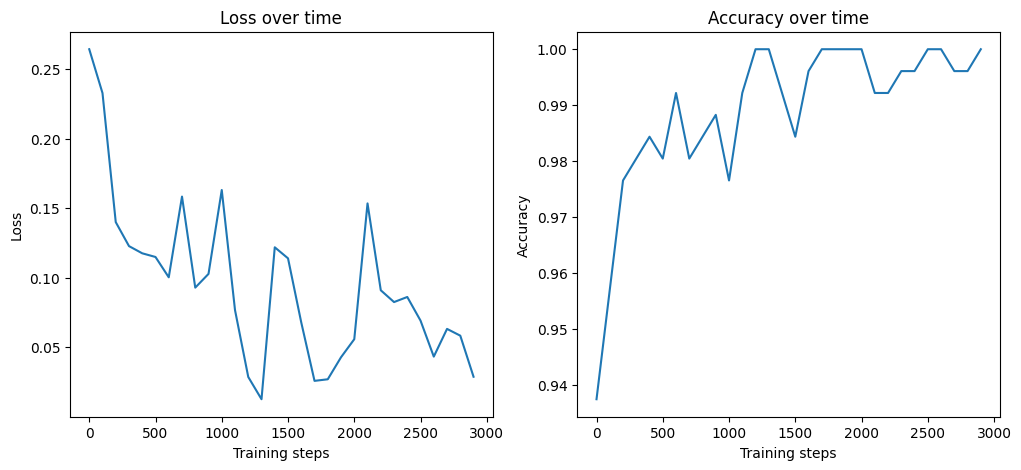

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, training_steps, display_step), loss_history)
plt.title("Loss over time")
plt.xlabel("Training steps")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(0, training_steps, display_step), accuracy_history)
plt.title("Accuracy over time")
plt.xlabel("Training steps")
plt.ylabel("Accuracy")

plt.show()

In [12]:
pred = neural_net(x_test)
test_acc = accuracy(pred, y_test).numpy()
print(f"Test Accuracy: {test_acc}")

from sklearn.metrics import classification_report

predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# classification_report
print(classification_report(y_test, predicted_labels))

Test Accuracy: 0.9739999771118164
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.96      0.99      0.97       982
           5       0.99      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.94      0.98      0.96       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



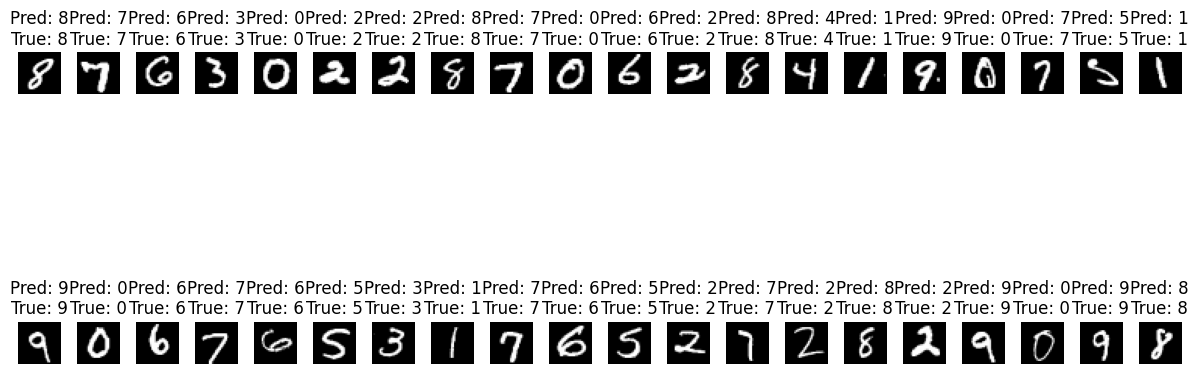

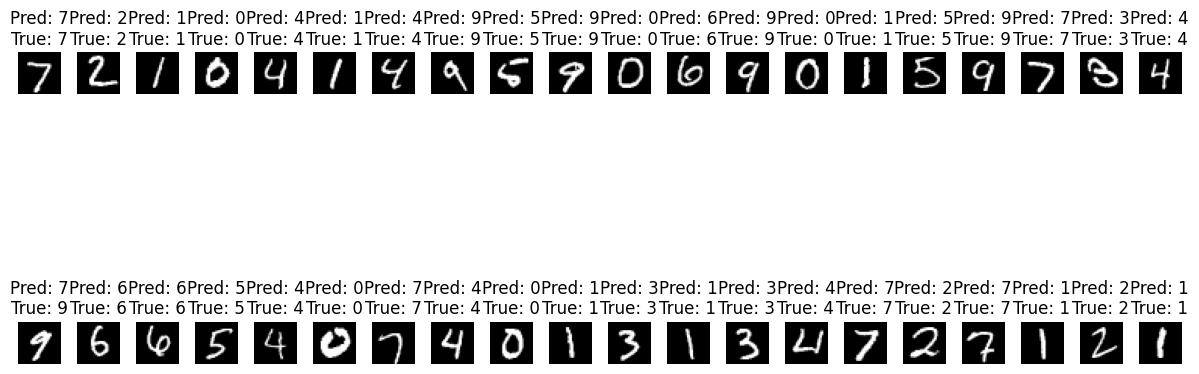

Neural network made 1 incorrect predicts out of 100. Error: 1.00%


In [13]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

def test_neural_network(total_tested):
    random_indices = random.sample(range(x_test.shape[0]), total_tested // 2)
    random_images = x_test[random_indices]
    random_labels = y_test[random_indices]

    predictions = neural_net(random_images)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    fig, axs = plt.subplots(2, total_tested // 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(2):
        for j in range(total_tested // 5):
            index = i * (total_tested // 5) + j
            axs[i, j].imshow(random_images[index].reshape(28, 28), cmap='gray')
            axs[i, j].set_title(f"Pred: {predicted_labels[index]}\nTrue: {random_labels[index]}")
            axs[i, j].axis('off')

    plt.show()

    test_images = x_test[:total_tested // 2]
    test_labels = y_test[:total_tested // 2]

    test_predictions = neural_net(test_images)
    test_predicted_labels = tf.argmax(test_predictions, axis=1).numpy()

    fig, axs = plt.subplots(2, total_tested // 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(2):
        for j in range(total_tested // 5):
            index = i * (total_tested // 5) + j
            axs[i, j].imshow(test_images[index].reshape(28, 28), cmap='gray')
            axs[i, j].set_title(f"Pred: {test_predicted_labels[index]}\nTrue: {test_labels[index]}")
            axs[i, j].axis('off')

    plt.show()

    errors = np.sum(predicted_labels != random_labels) + np.sum(test_predicted_labels != test_labels)
    error_rate = errors / total_tested
    print(f"Neural network made {errors} incorrect predicts out of {total_tested}. Error: {error_rate * 100:.2f}%")

# Number to test
total_tested = 100
test_neural_network(total_tested)

Використав Adam через кращi результати. Коли Adam помиляється 1-2 рази на 200 випадків, SGD 15-20 разів на 100 випадків.